In [1]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4XXIME4osGrMRA', sep = ';')
users_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/yJFydMNNGkEKfg', sep = ';')
users_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/br6KkQupzzTGoQ', sep = ';')
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/gvCWpZ55ODzs2g', sep = ';')
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VY5W0keMX5TZBQ', sep = ';')
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/th5GL0mGOc-qzg', sep = ';')

### 1) Предобработка данных

#### 1.1. EDA ####

***Cначала посмотрим на данные users***.

In [3]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [4]:
users_test.shape

(4308, 13)

In [5]:
#проверим, все ли пользователи уникальны
users_test['uid'].nunique()

4308

Все пользователи уникальны

In [6]:
#посмотрим на типы данных
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [7]:
#посмотрим, есть ли пропуски в данных
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

В некоторых колонках - пропуски:
- *coins* (у пользователя нет внутренней валюты монеток)
- *visit_days* (пользователь зарегистрировался, но не посещал приложение ни дня)
- *was_premium* (у пользователя не было ранее премиум-подписки, т.е. 0, т.к. наличие подписки - это 1)
- *is_premium* (у пользователя на настоящий момент отсутствует премиум-подписка)

In [8]:
#в колонках с пустыми значениями заменим NaN на 0
users_test['coins'] = users_test['coins'].fillna(0)
users_test['visit_days'] = users_test['visit_days'].fillna(0)
users_test['was_premium'] = users_test['was_premium'].fillna(0)
users_test['is_premium'] = users_test['is_premium'].fillna(0)

In [9]:
#посмотрим на обобщенную статистику
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,8.917437e+08,31.889276,316.411328,2.614206,0.953110,26.701486,38.248839,50.391133,0.094708,0.036444,534.080316
std,4.547670e+05,10.245287,323.373725,129.608910,0.211427,9.390851,15.344562,318.676437,0.292845,0.187414,4371.682632
min,8.910511e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913621e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917290e+08,30.000000,250.000000,0.000000,1.000000,24.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920952e+08,38.000000,520.250000,0.000000,1.000000,32.000000,44.000000,22.000000,0.000000,0.000000,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.000000,1.000000,129870.000000


Предварительный просмотр: Средний возраст пользователя в тестовой группе - 31.88(можно сказать 32 года), минимальный возраст - 16 лет , максимальный - 99 лет. 
Гендер - два значения 0 и 1 (возможно, 0 - женщина, а 1 - мужчина, но необязательно). Была или есть премиум-подписка (пробная или без пробной) также два значения - 0(нет) и 1(да).

In [10]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [11]:
users_control_1.shape

(4340, 13)

In [12]:
#проверим все ли пользователи уникальны
users_control_1['uid'].nunique()

4340

В первой контрольной группе все пользователи уникальны

In [13]:
#посмотрим на типы данных
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [14]:
#посмотрим, есть ли пропуски в данных
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

Ситуация анологична тестовой группе, поэтому заменим пропуски нулями по аналогии.

In [15]:
#в колонках с пустыми значениями заменим NaN на 0
users_control_1['coins'] = users_control_1['coins'].fillna(0)
users_control_1['visit_days'] = users_control_1['visit_days'].fillna(0)
users_control_1['was_premium'] = users_control_1['was_premium'].fillna(0)
users_control_1['is_premium'] = users_control_1['is_premium'].fillna(0)

In [16]:
#посмотрим на обобщенную статистику
users_control_1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000
mean,8.917578e+08,32.095392,312.048848,24.136866,0.958065,26.793779,38.553226,44.467512,0.100461,0.044240,594.761982
std,1.125683e+06,10.257466,320.972130,1518.279250,0.200465,9.405103,15.226951,204.800272,0.300648,0.205651,7987.922925
min,8.910510e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913626e+08,24.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917272e+08,30.000000,238.500000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920898e+08,38.000000,518.000000,0.000000,1.000000,32.000000,45.000000,21.000000,0.000000,0.000000,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,4953.000000,1.000000,1.000000,486330.000000


Краткий предварительный обзор: Средний возраст пользователя в первой контрольной группе совпадает с тестовой - 32 года, минимальный возраст совпадает с тестовой группой - 16 лет , максимальный также совпадает с тестовой - 99 лет. 
Гендер - два значения 0 и 1 (аналогично в тестовой). Была или есть премиум-подписка(пробная или без пробной) также два значения - 0(нет) и 1(да) (аналогично в тестовой). 

In [17]:
users_control_2.shape

(4264, 13)

In [18]:
#проверим все ли пользователи уникальны
users_control_2['uid'].nunique()

4264

Все пользователи во второй контрольной группе уникальны

In [19]:
#посмотрим на типы данных
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [20]:
#посмотрим, есть ли пропуски в данных
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

Ситуация анологична тестовой  и первой контрольной группам, поэтому заменим пропуски нулями по аналогии.

In [21]:
#в колонках с пустыми значениями заменим NaN на 0
users_control_2['coins'] = users_control_2['coins'].fillna(0)
users_control_2['visit_days'] = users_control_2['visit_days'].fillna(0)
users_control_2['was_premium'] = users_control_2['was_premium'].fillna(0)
users_control_2['is_premium'] = users_control_2['is_premium'].fillna(0)

In [22]:
#посмотрим на обобщенную статистику
users_control_2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000
mean,8.917694e+08,32.046201,317.957317,0.259615,0.954268,26.954268,38.906895,45.064493,0.096388,0.044794,450.384146
std,2.520759e+06,10.170721,326.191737,4.724639,0.208927,9.546657,15.955574,318.188992,0.295158,0.206875,2859.242228
min,8.910509e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913453e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917205e+08,30.000000,250.000000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920735e+08,38.000000,548.500000,0.000000,1.000000,32.000000,45.000000,20.000000,0.000000,0.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.000000,1.000000,81796.000000


Краткий предварительный обзор: Средний возраст пользователя во второй контрольной группе (как в первой контрольной и тестовой) - 32 года, минимальный возраст - 16 лет , максимальный - 99 лет (совпадает также с двумя другими группами). 
Гендер - два значения 0 и 1 (аналогично в двух других группах). Была или есть премиум-подписка(пробная или без пробной) также два значения - 0(нет) и 1(да) (аналогично в двух других группах). 

Теперь нам следует проверить, что выборки тестовой и контрольных групп независимы, т.е. пользователи из одной группы не присутствуют в двух других.

In [23]:
duplicates = users_test[users_test['uid'].isin(users_control_1['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из тестовой и контрольной групп не пересекаются.")

Пользователи из тестовой и контрольной групп не пересекаются.


In [24]:
duplicates = users_test[users_test['uid'].isin(users_control_2['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из тестовой и контрольной групп не пересекаются.")

Пользователи из тестовой и контрольной групп не пересекаются.


In [25]:
duplicates = users_control_1[users_control_1['uid'].isin(users_control_2['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из контрольных групп не пересекаются.")

Пользователи из контрольных групп не пересекаются.


Выборки пользователей в датасетах users_test, users_control_1 и users_control_2 независимы.

***Теперь проанализируем transactions во всех 3 группах***

In [26]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [27]:
transactions_test.shape

(273, 8)

In [28]:
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

Две колонки имеют сведения о регистрации пользователя (*joined_at*) и покупке того или иного продукта пользователем (*paid_at*), поэтому будет лучше привести эти колонки к формату даты.

In [29]:
transactions_test['joined_at'] = transactions_test['joined_at'].astype('datetime64')
transactions_test['paid_at'] = transactions_test['paid_at'].astype('datetime64')

In [30]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

Проверим датасет на корректность дат, т.е. дата регистрации должна быть меньше даты покупки

In [31]:
#посмотрим есть ли пользователии, у которых 'joined_at' > 'paid_at'
transactions_test.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins
37,892037613,United States of America,2017-10-22 11:48:00,2017-04-11 00:59:00,897,19,empty_likes,coins
38,892065108,France,2017-10-21 20:40:00,2017-08-11 22:45:00,7098,147,popular_users_chat,premium_no_trial
47,891640689,France,2017-10-30 13:47:00,2017-06-11 17:31:00,16432,147,none,trial_premium
56,892261437,Italy,2017-10-17 14:22:00,2017-06-11 11:51:00,1898,68,none,premium_no_trial
58,891764031,Belgium,2017-10-28 06:09:00,2017-04-11 11:09:00,12766,147,trial_vip_popup,trial_premium


In [32]:
transactions_test.query('joined_at > paid_at').shape

(47, 8)

In [33]:
transactions_test.query('joined_at > paid_at')['uid'].nunique()

35

Получается, что есть пользователи в количестве 35 человек, которые зарегистрировались позже, чем совершили какую-то операцию по покупке(или несколько таких операций). Возможно, в системе произошел сбой, который привел к неверной записи в колонке *paid_at*, поэтому удалим такие 47 транзакций. + Так как транзакции данных 35 пользователей подлежат удалению, то и самих пользователей также нужно исключить из датасета users_test.

In [34]:
transactions_test.query('joined_at > paid_at').index

Int64Index([ 11,  20,  24,  25,  36,  37,  38,  47,  56,  58,  62,  64,  71,
             74,  77,  82,  84,  92, 100, 101, 108, 114, 118, 128, 137, 161,
            162, 175, 177, 178, 183, 184, 185, 190, 197, 200, 213, 217, 222,
            225, 231, 237, 244, 245, 248, 260, 265],
           dtype='int64')

In [35]:
del_users = transactions_test.query('joined_at > paid_at')['uid'].unique()

In [36]:
transactions_test = transactions_test.drop(index = [11,  20,  24,  25,  36,  37,  38,  47,  56,  58,  62,  64,  71,
             74,  77,  82,  84,  92, 100, 101, 108, 114, 118, 128, 137, 161,
            162, 175, 177, 178, 183, 184, 185, 190, 197, 200, 213, 217, 222,
            225, 231, 237, 244, 245, 248, 260, 26])

In [37]:
users_test = users_test.query('uid not in @del_users')

Проверим, нет ли пропусков в скорректированном датасете

In [38]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Проверим нет ли дублей.

In [39]:
transactions_test.duplicated().sum()

7

Посмотрим, что это за дубли.

In [40]:
transactions_test[transactions_test.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


Дубликаты касаются в основном покупки монет или какого-то другого типа продукта. Поскольку купить один и тот же продукт одновременно вплоть до секунды невозможно (paid_at), то, вероятно, тут имеет место  сбой в транзакциях, и одна и та же транзакция записалась системой дважды. Уберем эти дубли.

In [41]:
transactions_test = transactions_test.drop_duplicates()

In [42]:
transactions_test.shape

(219, 8)

In [43]:
transactions_test['uid'].nunique()

129

В тестовой группе пока остается 219 транзакций 129 пользователей.

*Посмотрим на транзакции из контрольных групп, проанализируем их по аналогии с тестовой*.

In [44]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [45]:
transactions_control_1.shape

(1007, 8)

По сравнению с тестовым датасет выглядит объемным, посмотрим сразу наличие пропущенных значений

In [46]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

В даннном датасете полностью нет информации по 630 транзакциям за исключеним дат регистрации и оплаты, которые в теории тоже могут быть некорректны, как было у некоторых пользователей в тестовой группе. Т.к. пропусков очень много, а воспроизвести все данные только по датам невозможно, то удалим эти 630 транзакций. Спишем все на некий баг в самой системе.

In [47]:
transactions_control_1 = transactions_control_1.dropna()

In [48]:
transactions_control_1.shape

(377, 8)

In [49]:
transactions_control_1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
dtype: object

Тип данных в колонках *payment_id*, *uid*, *revenue* почему-то 'float', а не 'int' как в тесте. Приведем все к 'int' как в тесте для унификации.

In [50]:
transactions_control_1['payment_id'] = transactions_control_1['payment_id'].astype('int64')
transactions_control_1['uid'] = transactions_control_1['uid'].astype('int64')
transactions_control_1['revenue'] = transactions_control_1['revenue'].astype('int64')
transactions_control_1.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [51]:
#поправим еще и тип данных в колонках с датами
transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'])
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'])

In [52]:
transactions_control_1.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [53]:
#посмотрим есть ли пользователии, у которых 'joined_at' > 'paid_at'
transactions_control_1.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602,146,empty_likes,coins
14,892277877,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897,19,empty_likes,coins
20,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305,19,autorefill,coins
21,891707061,Argentina,2017-10-29 10:54:00,2017-04-11 00:30:00,1261,19,empty_likes,coins
23,891707061,Argentina,2017-10-29 10:54:00,2017-10-11 00:04:00,1261,19,autorefill,coins
24,892207959,France,2017-10-18 18:30:00,2017-01-11 04:39:00,1261,19,empty_likes,coins
32,891671796,Canada,2017-10-29 22:06:00,2017-06-11 00:06:00,9854,147,trial_vip_popup,trial_premium
51,891707061,Argentina,2017-10-29 10:54:00,2017-07-11 23:53:00,1261,19,menu,coins
54,891850512,Portugal,2017-10-26 10:34:00,2017-02-11 13:43:00,5577,147,trial_vip_popup,trial_premium
59,891693753,Turkey,2017-10-29 15:24:00,2017-04-11 20:45:00,5304,19,empty_likes,coins


In [54]:
transactions_control_1.query('joined_at > paid_at').shape

(55, 8)

In [55]:
transactions_control_1.query('joined_at > paid_at')['uid'].nunique()

37

Аналогичная ситуация как и в тестовой группе, поэтому удалим 55 транзакций данных 37 пользователей. + Так как транзакции данных 37 пользователей подлежат удалению, то и самих пользователей также нужно исключить из датасета users_control_1.

In [56]:
transactions_control_1.query('joined_at > paid_at').index

Int64Index([  5,  14,  20,  21,  23,  24,  32,  51,  54,  59,  61,  66,  72,
             73,  77,  79,  87,  90,  94, 100, 104, 124, 128, 133, 147, 150,
            161, 173, 187, 190, 192, 199, 201, 213, 214, 226, 243, 247, 254,
            262, 263, 272, 275, 276, 291, 293, 299, 321, 327, 337, 340, 345,
            355, 360, 374],
           dtype='int64')

In [57]:
del_users_1 = transactions_control_1.query('joined_at > paid_at')['uid'].unique()

In [58]:
transactions_control_1 = transactions_control_1.drop(index = [ 5,  14,  20,  21,  23,  24,  32,  51,  54,  59,  61,  66,  72,
             73,  77,  79,  87,  90,  94, 100, 104, 124, 128, 133, 147, 150,
            161, 173, 187, 190, 192, 199, 201, 213, 214, 226, 243, 247, 254,
            262, 263, 272, 275, 276, 291, 293, 299, 321, 327, 337, 340, 345,
            355, 360, 374])

In [59]:
users_control_1 = users_control_1.query('uid not in @del_users_1')

Здесь тоже посмотрим есть ли дубли и удалим их, если они есть (по аналогии с тестовой группой).

In [60]:
transactions_control_1.duplicated().sum()

21

In [61]:
transactions_control_1[transactions_control_1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783,67,menu,other_type
88,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783,67,empty_admins,other_type
93,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469,19,sympathy,other_type
169,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783,67,menu,other_type
176,892207959,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261,19,empty_likes,coins
198,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783,67,empty_admins,other_type
206,891739737,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261,19,empty_likes,coins
216,891452706,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305,19,gifts,coins
223,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897,19,empty_likes,coins
233,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261,19,empty_likes,coins


In [62]:
transactions_control_1 = transactions_control_1.drop_duplicates()

In [63]:
transactions_control_1.shape

(301, 8)

In [64]:
transactions_control_1['uid'].nunique()

169

В первой контрольной группе пока остается 301 транзакция 169 пользователей.

In [65]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [66]:
transactions_control_2.shape

(328, 8)

In [67]:
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Пустые значения в датасете *transactions_control_2* отсутствуют

In [68]:
transactions_control_2.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [69]:
#здесь тоже поправим тип данных в колонках с датами
transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'])
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'])

In [70]:
transactions_control_2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [71]:
#посмотрим есть ли пользователии, у которых 'joined_at' > 'paid_at'
transactions_control_2.query('joined_at > paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium
19,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:14:00,3783,67,empty_likes,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins
25,891897387,Australia,2017-10-25 10:44:00,2017-02-11 12:44:00,13208,147,trial_vip_popup,trial_premium
30,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:48:00,3783,67,gifts,other_type
33,891647544,Israel,2017-10-30 10:14:00,2017-06-11 12:31:00,11102,147,trial_vip_popup,trial_premium
41,892354854,France,2017-10-15 18:51:00,2017-05-11 16:02:00,3900,146,menu,coins
49,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,2327,67,empty_mutual,other_type


In [72]:
transactions_control_2.query('joined_at > paid_at').shape

(60, 8)

In [73]:
transactions_control_2.query('joined_at > paid_at')['uid'].nunique()

41

Ситуация анологична двум предыдущим группам, также удаляем 60 транзакций 41 пользователя. + 41 пользователя, совершивших эти транзакции.

In [74]:
transactions_control_2.query('joined_at > paid_at').index

Int64Index([  1,   4,  14,  19,  20,  25,  30,  33,  41,  49,  54,  57,  58,
             60,  62,  66,  74,  75,  88,  97, 110, 116, 124, 129, 132, 138,
            143, 147, 149, 153, 162, 174, 179, 188, 190, 197, 198, 227, 232,
            233, 239, 250, 255, 262, 267, 275, 278, 279, 283, 284, 290, 291,
            292, 293, 304, 305, 313, 314, 315, 319],
           dtype='int64')

In [75]:
del_users_2 = transactions_control_2.query('joined_at > paid_at')['uid'].unique()

In [76]:
transactions_control_2 = transactions_control_2.drop(index = [1,   4,  14,  19,  20,  25,  30,  33,  41,  49,  54,  57,  58,
             60,  62,  66,  74,  75,  88,  97, 110, 116, 124, 129, 132, 138,
            143, 147, 149, 153, 162, 174, 179, 188, 190, 197, 198, 227, 232,
            233, 239, 250, 255, 262, 267, 275, 278, 279, 283, 284, 290, 291,
            292, 293, 304, 305, 313, 314, 315, 319])

In [77]:
users_control_2 = users_control_2.query('uid not in @del_users_2')

Здесь тоже посмотрим есть ли дубли и удалим их, если они есть.

In [78]:
transactions_control_2.duplicated().sum()

5

In [79]:
transactions_control_2[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [80]:
transactions_control_2 = transactions_control_2.drop_duplicates()

In [81]:
transactions_control_2.shape

(263, 8)

In [82]:
transactions_control_2['uid'].nunique()

154

Во второй контрольной группе пока остается 263 транзакции 154 пользователей.

Здесь тоже проверяем независимость данных в группах, т.е. пользователи из одной группы не присутствуют в двух других.

In [83]:
duplicates = transactions_test[transactions_test['uid'].isin(transactions_control_1['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из тестовой и контрольной групп не пересекаются.")

Пользователи из тестовой и контрольной групп не пересекаются.


In [84]:
duplicates = transactions_test[transactions_test['uid'].isin(transactions_control_2['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из тестовой и контрольной групп не пересекаются.")

Пользователи из тестовой и контрольной групп не пересекаются.


In [85]:
duplicates = transactions_control_1[transactions_control_1['uid'].isin(transactions_control_2['uid'])]

if not duplicates.empty:
    print(f"Найдены дубликаты пользователей:{duplicates}")
else:
    print("Пользователи из контрольных групп не пересекаются.")

Пользователи из контрольных групп не пересекаются.


Посмотрим на все датасеты users и transactions после чистки данных.

In [86]:
users_test.shape, users_test['uid'].nunique()

((4273, 13), 4273)

In [87]:
users_control_1.shape, users_control_1['uid'].nunique()

((4303, 13), 4303)

In [88]:
users_control_2.shape, users_control_2['uid'].nunique()

((4223, 13), 4223)

In [89]:
transactions_test.shape

(219, 8)

In [90]:
transactions_control_1.shape

(301, 8)

In [91]:
transactions_control_2.shape

(263, 8)

#### 1.2. Формирование групп ####

Из условия нашего эксперимента следует, что A/B тест был проведен:
 - для новых пользователей из нескольких стран (далее - пользователи);
 - для пользователей была изменена стоимость премиум-подписки (*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит*);
 - покупка проходила через две новые платежные системы. 
        
**NB**: При этом стоимость пробного периода оставалась прежней.

1) Отберем новых пользователей по дате регистрации (даты в 3 группах (тестовая и 2 контрольные) должны совпадать)

In [92]:
transactions_test['joined_at'].min(), transactions_test['joined_at'].max()

(Timestamp('2017-01-11 03:07:00'), Timestamp('2017-10-31 23:40:00'))

In [93]:
transactions_control_1['joined_at'].min(), transactions_control_1['joined_at'].max()

(Timestamp('2015-01-19 11:49:00'), Timestamp('2017-10-31 03:34:00'))

In [94]:
transactions_control_2['joined_at'].min(), transactions_control_2['joined_at'].max()

(Timestamp('2017-01-11 08:36:00'), Timestamp('2017-10-30 19:29:00'))

Диапазон дат разный. В первой контрольной группе самая ранняя дата регистрации начинается аж в 2015 году, нужно посмотреть, что это за пользователи.

In [95]:
transactions_control_1.query('joined_at == "2015-01-19 11:49:00"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


Пользователь один и тот же, от даты регистрации в 2015 году до даты покупок в 2016 году прошел почти год. Может, это был какой-то тестировщик приложения? В любом случае, данные транзакции удаляем.

In [96]:
transactions_control_1.query('joined_at == "2015-01-19 11:49:00"').index

Int64Index([65, 101, 224], dtype='int64')

In [97]:
transactions_control_1 = transactions_control_1.drop(index = [65, 101, 224])
transactions_control_1['joined_at'].min(), transactions_control_1['joined_at'].max()

(Timestamp('2017-01-11 01:06:00'), Timestamp('2017-10-31 03:34:00'))

Однако данного пользователя (uid = 960936960.0) стоит еще и удалить из users_control_1

In [98]:
users_control_1.query('uid == 960936960.0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26


In [99]:
users_control_1 = users_control_1.drop(index = 510)

Для корректного проведения эксперимента оставим пользователей, зарегистрировавшихся с 11 января по 30 октября 2017. 11 января 2017 у всех совпадает, теперь оставим совпадение по дате окончания.

In [100]:
# Определение общего временного диапазона (только даты)
end_date = pd.to_datetime('2017-10-30').date()

In [101]:
#нахождение пользователей вне данного диапазона в тестовой группе
transactions_test[transactions_test['joined_at'].dt.date > end_date]['uid'].unique()

array([891605694, 891603810, 891564672, 891589239, 891572565])

In [102]:
#удаляем этих пользователей из users_test
a = [891605694, 891603810, 891564672, 891589239, 891572565]
users_test = users_test.query('uid not in @a')

In [103]:
#нахождение пользователей вне данного диапазона в первой контрольной группе
transactions_control_1[transactions_control_1['joined_at'].dt.date > end_date]['uid'].unique()

array([891607515])

In [104]:
#удаляем этих пользователей из users_control_1
users_control_1 = users_control_1.query('uid != 891607515')

In [105]:
# Фильтрация пользователей по дате регистрации (игнорируя время) теперь в транзакциях
transactions_test = transactions_test[transactions_test['joined_at'].dt.date <= end_date]
transactions_control_1 = transactions_control_1[transactions_control_1['joined_at'].dt.date <= end_date]

In [106]:
transactions_test['joined_at'].min(), transactions_test['joined_at'].max()

(Timestamp('2017-01-11 03:07:00'), Timestamp('2017-10-30 23:01:00'))

In [107]:
transactions_control_1['joined_at'].min(), transactions_control_1['joined_at'].max()

(Timestamp('2017-01-11 01:06:00'), Timestamp('2017-10-30 23:53:00'))

In [108]:
transactions_control_2['joined_at'].min(), transactions_control_2['joined_at'].max()

(Timestamp('2017-01-11 08:36:00'), Timestamp('2017-10-30 19:29:00'))

Теперь даты регистрации *с 2017-01-11* *по 2017-10-30* совпадают во всех 3 группах. По времени регистрации отбирать будет уже перебор, достаточно совпадения дат.

Теперь еще важно посмотреть на сроки оплат во всех трех группах:

In [109]:
transactions_test['paid_at'].min(), transactions_test['paid_at'].max()

(Timestamp('2017-02-11 13:43:00'), Timestamp('2017-12-11 22:06:00'))

In [110]:
transactions_control_1['paid_at'].min(), transactions_control_1['paid_at'].max()

(Timestamp('2017-01-11 05:16:00'), Timestamp('2017-12-11 21:57:00'))

In [111]:
transactions_control_2['paid_at'].min(), transactions_control_2['paid_at'].max()

(Timestamp('2017-02-11 21:52:00'), Timestamp('2017-12-11 23:28:00'))

Видим, что последние транзакции во всех группах от 11 декабря 2017, однако, транзакции в первой контрольной группе начались на месяц раньше, чем в тестовой и во второй контрольной группе. Таким образом, чтобы выровнять период эксперимента по транзакциям,в первой контрольной группе нам нужно исключить из эксперимента транзакции, которые были совершены в январе 2017 + исключить пользователей, их совершивших.

In [112]:
transactions_control_1.query('paid_at < "2017-02-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
342,891561825,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913,146,empty_likes,coins
362,891543996,United States of America,2017-01-11 13:42:00,2017-01-11 14:41:00,6292,147,user_profile,premium_no_trial
372,891556971,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886,68,none,premium_no_trial


In [113]:
transactions_control_1.query("uid == 891561825 or uid == 891543996 or uid == 891556971")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
196,891561825,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636,147,trial_vip_popup,trial_premium
342,891561825,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913,146,empty_likes,coins
362,891543996,United States of America,2017-01-11 13:42:00,2017-01-11 14:41:00,6292,147,user_profile,premium_no_trial
368,891561825,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900,19,empty_likes,coins
372,891556971,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886,68,none,premium_no_trial


И так, что мы видим, есть пользователи с транзакциями только в январе и все, транзакции удаляем, пользователей тоже. Есть один пользователь с транзакцией в январе и в другие периоды. Транзакция в январе у него связна с покупкой монеток, следующая транзакция у него от апреля, и снова покупка монеток; и только в августе этот пользователь купил пробную версию. Т.к. наш эксперимент касается изменения стоимости премиум-подписки, а данный пользователь ее не приобретал, то его тоже следует исключить из эксперимента.

In [114]:
users_control_1.query("uid == 891561825 or uid == 891543996 or uid == 891556971")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
3398,891561825,32,208,8.0,France,"1,2,3,4,5,8,11",1,29,35,24,1.0,1.0,20449
3749,891556971,35,666,0.0,France,"1,3",1,32,38,3,1.0,0.0,2886
4231,891543996,50,508,0.0,United States of America,0,1,26,53,120,1.0,1.0,6292


In [115]:
transactions_control_1 = transactions_control_1.drop(index = [196, 342, 362, 368, 372])
users_control_1 = users_control_1.drop(index = [3398, 3749, 4231])

2) Теперь нужно посмотреть на страны во всех датасетах и оставить только страны, которые есть во всех 3 группах.

In [116]:
#посмотрим на тестовую группу
users_test['country'].nunique()

51

In [117]:
transactions_test['country'].nunique()

16

В тестовой группе представлена 51 страна, однако, транзакции прошли только в 16 странах из 51. В данном случае следует оставить только страны из транзакций, т.к. изменения коснулись пользователей с премиум-подпиской, премиум-подписка сама по себе предполагает наличие транзакции.

In [118]:
selected_t_test = transactions_test['country'].unique()

In [119]:
users_test = users_test.query('country in @selected_t_test')
users_test['country'].unique(), users_test['country'].nunique()

(array(['United States of America', 'Germany', 'Israel', 'France', 'Spain',
        'Italy', 'Argentina', 'Belgium', 'Chile',
        'United Kingdom (Great Britain)', 'United Arab Emirates', 'Canada',
        'Switzerland', 'Mexico', 'Latvia', 'Turkey'], dtype=object),
 16)

In [120]:
# посмотрим на первую контрольную группу
users_control_1['country'].nunique()

40

In [121]:
transactions_control_1['country'].nunique()

17

В первой контрольной группе представлено 40 стран, транзакции прошли только в 17 странах из 40. Оставляем только страны с транзакциями по аналогии с тестовой группой.

In [122]:
selected_t_control_1 = transactions_control_1['country'].unique()

In [123]:
users_control_1 = users_control_1.query('country in @selected_t_control_1')
users_control_1['country'].unique(), users_control_1['country'].nunique()

(array(['United States of America', 'France', 'Argentina', 'Chile',
        'Italy', 'Australia', 'Germany', 'Spain', 'Israel',
        'United Kingdom (Great Britain)', 'United Arab Emirates',
        'Belgium', 'Portugal', 'Canada', 'Switzerland', 'India', 'Turkey'],
       dtype=object),
 17)

In [124]:
# посмотрим на вторую контрольную группу
users_control_2['country'].nunique()

44

In [125]:
transactions_control_2['country'].nunique()

17

Во второй контрольной группе представлено 44 страны, транзакции прошли только в 17 странах из 44. Оставляем только страны с транзакциями по аналогии с предыдущими группами.

In [126]:
selected_t_control_2 = transactions_control_2['country'].unique()

In [127]:
users_control_2 = users_control_2.query('country in @selected_t_control_2')
users_control_2['country'].unique(), users_control_2['country'].nunique()

(array(['Israel', 'Italy', 'France', 'United States of America', 'Chile',
        'Spain', 'United Arab Emirates', 'Argentina', 'Portugal',
        'Germany', 'Belgium', 'United Kingdom (Great Britain)', 'Canada',
        'Australia', 'Ukraine', 'Switzerland', 'Turkey'], dtype=object),
 17)

Теперь следует создать общий список стран для всех групп, а затем еще раз отфильтроваться по нему.

In [128]:
# отфильтруемся только по transactions т.к. страны в users и transactions уже совпадают
united_countries = list(transactions_test.query('country in @selected_t_control_1 and country in @selected_t_control_2')['country'].unique())
united_countries                              

['Italy',
 'United States of America',
 'Spain',
 'United Arab Emirates',
 'Argentina',
 'Canada',
 'United Kingdom (Great Britain)',
 'France',
 'Israel',
 'Switzerland',
 'Germany',
 'Chile',
 'Turkey',
 'Belgium']

In [129]:
users_test = users_test.query('country in @united_countries')
users_control_1 = users_control_1.query('country in @united_countries')
users_control_2 = users_control_2.query('country in @united_countries')

transactions_test = transactions_test.query('country in @united_countries')
transactions_control_1 = transactions_control_1.query('country in @united_countries')
transactions_control_2 = transactions_control_2.query('country in @united_countries')

3) Теперь осталось отобрать две платежные системы, т.к. изменения в тесте коснулись премиум-подписки, то следует посмотреть через какие системы оплаты идет транзакция по премиум-подписке

In [130]:
transactions_test.query('product_type == "premium_no_trial"')['payment_id'].unique()

array([147,  68,   0])

In [131]:
transactions_control_1.query('product_type == "premium_no_trial"')['payment_id'].unique()

array([147,  68,   0])

In [132]:
transactions_control_2.query('product_type == "premium_no_trial"')['payment_id'].unique()

array([147,  68])

Две платежные системы во всех группах - 147 и 68. Посмотрим, что за лишняя система 0, много ли пользователей заплатили через нее.

In [133]:
transactions_test.query('payment_id == 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
220,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial


In [134]:
users_test.query('uid == 891725043')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2935,891725043,28,282,0.0,United Arab Emirates,"1,2,3,4,5,6,8,9,10,12,13,15,16,17",1,25,31,117,1.0,1.0,18434


In [135]:
transactions_control_1.query('payment_id == 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
138,891216033,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292,0,autoreply_message,premium_no_trial
347,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422,0,none,premium_no_trial


In [136]:
users_control_1.query('uid == 891216033 or uid == 892101909')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1215,892101909,25,531,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,21,2...",1,22,28,32,1.0,1.0,14508
3789,891216033,20,1000,0.0,United States of America,"1,2",1,17,25,2,1.0,1.0,12584


В тестовой группе через систему 0 платил 1 пользователь, в первой контрольной - 2 пользователя. Т.к. пользователей с системой 0 очень мало, то, вероятно, тут какая-то ошибка в данных. Поэтому исключим эту систему оплаты из групп, ведь в условии у нас - две платежные системы.

In [137]:
transactions_test = transactions_test.query('payment_id == 68 or payment_id == 147')
users_test = users_test.drop(index = 2935)

transactions_control_1 = transactions_control_1.query('payment_id == 68 or payment_id == 147')
users_control_1 = users_control_1.drop(index = [1215, 3789])
transactions_control_2 = transactions_control_2.query('payment_id == 68 or payment_id == 147')

Теперь в users оставим только пользователей из transactions по двум системам оплаты.

In [138]:
users_test = users_test.query('uid in @transactions_test.uid.unique()')
users_control_1 = users_control_1.query('uid in @transactions_control_1.uid.unique()')
users_control_2 = users_control_2.query('uid in @transactions_control_2.uid.unique()')

Теперь отфильтруемся наоборот, т.к. в в transactions могут остаться пользователи, которых нет в users, может появиться разница в количестве уникальных пользователей.

In [139]:
transactions_test = transactions_test.query('uid in @users_test.uid.unique()')
transactions_control_1 = transactions_control_1.query('uid in @users_control_1.uid.unique()')
transactions_control_2 = transactions_control_2.query('uid in @users_control_2.uid.unique()')

In [140]:
users_test['uid'].nunique(), users_control_1['uid'].nunique(), users_control_2['uid'].nunique()

(90, 124, 113)

In [141]:
90 + 124 + 113

327

In [142]:
transactions_test.shape, transactions_test['uid'].nunique()

((93, 8), 90)

In [143]:
transactions_control_1.shape, transactions_control_1['uid'].nunique()

((126, 8), 124)

In [144]:
transactions_control_2.shape, transactions_control_2['uid'].nunique()

((116, 8), 113)

И так, что мы видим: транзакциях во всех группах пользователей меньше, чем операций, совершенных ими (хотя количество уникальных пользователей в users и transactions по группам совпадает). Посмотрим на пользователей, совершивших в рамках эксперимента не одно действие.

In [145]:
transactions_test[transactions_test.duplicated(subset='uid', keep=False)].sort_values('uid', ascending = False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
79,892097937,Chile,2017-10-21 06:24:00,2017-10-31 03:22:00,8086,147,popular_users_chat,premium_no_trial
120,892097937,Chile,2017-10-21 06:24:00,2017-10-22 12:58:00,8216,147,popular_users_chat,premium_no_trial
171,892097937,Chile,2017-10-21 06:24:00,2017-10-23 13:56:00,8229,147,popular_users_chat,premium_no_trial
107,891297711,Spain,2017-06-11 01:35:00,2017-11-13 03:46:00,12818,147,trial_vip_popup,trial_premium
181,891297711,Spain,2017-06-11 01:35:00,2017-11-13 03:42:00,12818,147,autoreply_message,trial_premium


Видно, что с пользователя из Испании, очевидно, списалась двойная оплата (две операции по покупке пробного периода день в день на одинаковую сумму). С пользователем из Чили, вероятно, немного иная история, которую достаточно трудно разгадать: возможно, пользователь пытался оформить премиум-подписку несколько раз, подгадывая выгодные для себя условия в октябре месяце, а система ошибочно ему записывала все попытки.Однако сумма очень разная... Во избежании искажений и домыслов транзакции пользователя из Чили удалим, а у пользователя из Испании оставим последнюю транзакцию. Пользователя из Чили также исключим из users_test.

In [146]:
transactions_test = transactions_test.drop(index = [79, 120, 171, 181])

In [147]:
users_test.query('uid == "892097937"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
553,892097937,17,124,6.0,Chile,"1,2,3,4,5,6,7,8,9,10,12,14,15,16,17,18,21,22,2...",1,14,20,193,1.0,1.0,28535


In [148]:
users_test = users_test.drop(index = 553)

In [149]:
transactions_control_1[transactions_control_1.duplicated(subset='uid', keep=False)].sort_values('uid', ascending = False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
42,892393119,Italy,2017-10-15 00:34:00,2017-10-21 13:10:00,1807,68,none,premium_no_trial
141,892393119,Italy,2017-10-15 00:34:00,2017-10-21 13:09:00,1807,68,none,premium_no_trial
228,891264903,United States of America,2017-06-11 16:02:00,2017-08-11 22:32:00,3887,147,none,premium_no_trial
351,891264903,United States of America,2017-06-11 16:02:00,2017-09-11 10:32:00,3874,147,none,premium_no_trial


В первой контрольной группе с пользователя из Италии тоже списалась двойная сумма за премиум-подписку(день в день с разницей в минуту). Что касается пользователя из США, то можно подумать, что дело в системе оплаты: деньги не дошли до банка, где-то зависнув, и списались через месяц, но сумма разная. Пользователю из Италии оставим последнюю транзакцию только, а пользователя из США удалим вместе с транзакциями.

In [150]:
transactions_control_1 = transactions_control_1.drop(index = [141, 228, 351])

In [151]:
users_control_1.query('uid == "891264903"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
187,891264903,19,239,0.0,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761


In [152]:
users_control_1 = users_control_1.drop(index = 187)

In [153]:
transactions_control_2[transactions_control_2.duplicated(subset='uid', keep=False)].sort_values('uid', ascending = False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
29,892435536,United States of America,2017-10-14 02:54:00,2017-10-14 02:57:00,4537,147,dating,premium_no_trial
195,892435536,United States of America,2017-10-14 02:54:00,2017-11-14 04:57:00,4537,147,dating,premium_no_trial
13,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-20 08:41:00,5135,147,autoreply_message,premium_no_trial
196,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-23 13:54:00,5161,147,promo_09,premium_no_trial
247,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-22 12:44:00,5161,147,promo_09,premium_no_trial


Во второй контрольной группе у пользователя из США, вероятно, оплата где-то зависла, и деньги списались только через месяц нормально (сумма одна и та же за премиум-подписку). У пользователя из Британии ситуация странная: в октябре три раза в разные дни снимались две разные суммы, то меньше, а потом больше... Ситуация похожа на ситуацию пользователя из Чили, поэтому с пользователем из Британии поступим аналогичным образом - удалим. Пользователю из США оставим последнюю транзакцию.

In [154]:
transactions_control_2 = transactions_control_2.drop(index = [29, 13, 196, 247])

In [155]:
users_control_2.query('uid == 892139829')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
593,892139829,28,594,8.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,20,35,170,1.0,1.0,22243


In [156]:
users_control_2 = users_control_2.drop(index = 593)

Так как нам не удалось избежать еще одного преобразования, то на финальном этапе еще раз проверим, что во всех users и transactions одинаковые страны, даты, а также платежные системы.

In [157]:
transactions_test['joined_at'].min(), transactions_test['joined_at'].max()

(Timestamp('2017-01-11 03:07:00'), Timestamp('2017-10-30 23:01:00'))

In [158]:
transactions_control_1['joined_at'].min(), transactions_control_1['joined_at'].max()

(Timestamp('2017-01-11 08:26:00'), Timestamp('2017-10-30 23:53:00'))

In [159]:
transactions_control_2['joined_at'].min(), transactions_control_2['joined_at'].max()

(Timestamp('2017-01-11 08:36:00'), Timestamp('2017-10-30 19:29:00'))

In [160]:
transactions_test['paid_at'].min(), transactions_test['paid_at'].max()

(Timestamp('2017-02-11 13:43:00'), Timestamp('2017-12-11 21:20:00'))

In [161]:
transactions_control_1['paid_at'].min(), transactions_control_1['paid_at'].max()

(Timestamp('2017-02-11 12:26:00'), Timestamp('2017-12-11 21:57:00'))

In [162]:
transactions_control_2['paid_at'].min(), transactions_control_2['paid_at'].max()

(Timestamp('2017-02-11 21:52:00'), Timestamp('2017-12-11 23:28:00'))

По датам все ок, изменений - нет.

In [163]:
transactions_test['payment_id'].unique(), transactions_control_1['payment_id'].unique(), transactions_control_2['payment_id'].unique(),

(array([147,  68]), array([147,  68]), array([147,  68]))

По двум платежным системам тоже все ок.

In [164]:
countries_control_1 = set(transactions_control_1['country'].unique()).union(set(users_control_1['country'].unique()))
countries_control_2 = set(transactions_control_2['country'].unique()).union(set(users_control_2['country'].unique()))
countries_test = set(transactions_test['country'].unique()).union(set(users_test['country'].unique()))

# Проверка на равенство
all_countries = countries_control_1 == countries_control_2 == countries_test

# Вывод результатов
print("Все группы имеют одинаковые страны:", all_countries)

Все группы имеют одинаковые страны: True


In [165]:
users_test['uid'].nunique(), users_control_1['uid'].nunique(), users_control_2['uid'].nunique()

(89, 123, 112)

In [166]:
89 + 123 + 112

324

In [167]:
transactions_test.shape, transactions_test['uid'].nunique()

((89, 8), 89)

In [168]:
transactions_control_1.shape, transactions_control_1['uid'].nunique()

((123, 8), 123)

In [169]:
transactions_control_2.shape, transactions_control_2['uid'].nunique()

((112, 8), 112)

Таким образом, в тестовой группе - 89 уникальных пользователей, в первой контрольной - 123, во второй контрольной - 112. Всего 324 уникальных пользователя. Период эксперимента с 11 января по 30 октября 2017 года. Платежные системы - 147 и 68. 14 стран. Теперь важно проверить корректность работы системы сплитования. Для этого проверим равенство распределений ключевых признаков между группами, которые могут оказать влияние на интерпретацию AB-тестирования.

### 2. Исследование системы сплитования пользователей по группам (датасеты user_test, user_control_1 и users_control_2)

Сначала посмотрим на **распределение пользователей по странам**. Для ускорения процесса сравнения создадим в каждой группе колонку 'group' с названием группы, а затем объединим датасеты в один.

In [170]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

In [171]:
users = pd.concat([users_test, users_control_1, users_control_2])

In [172]:
countries_df = users.groupby(['country', 'group'], as_index = False).agg({'uid': 'count'})

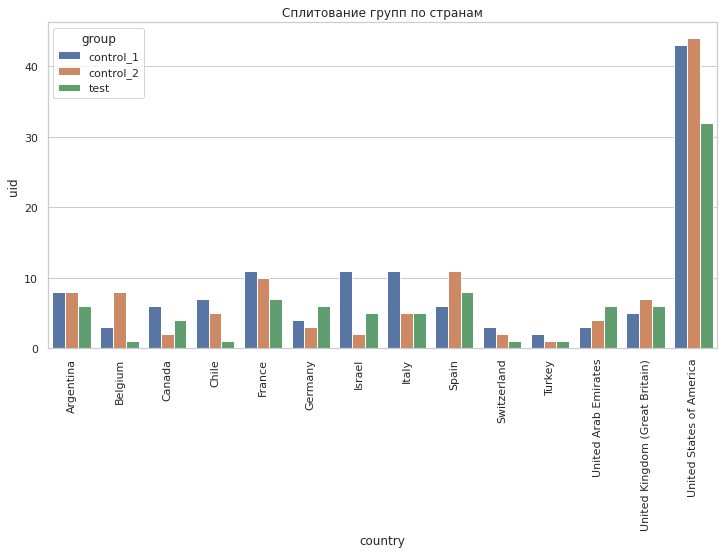

In [173]:
sns.barplot(data = countries_df, x = 'country', y = 'uid', hue = 'group').set_title('Сплитование групп по странам')
plt.xticks(rotation=90)
plt.show()

Визуально кажется, что различия в количестве уникальных пользователей по странам есть. Но проверим это статистически.
У нас есть три группы:  test - версия с изменениями, control_1 и control_2 - версии без изменений, а также колонка 'страна', т.к. все переменные - категориальные → нужен хи-квадрат.

- $H_0$: Не обнаружено статистически значимых различий между распределениями пользователей по странам в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями пользователей по странам в тестовой и контрольных группах.

In [174]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(users.country, users.group))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 26.475943065129815
P-значение теста: 0.4371973338953261


In [175]:
0.4371973338953261 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями пользователей по странам в тестовой и контрольных группах нет. 

Посмотрим на **распределение пользователей по гендеру**. 

In [176]:
gender_df = users.groupby(['gender', 'group'], as_index = False).agg({'uid': 'count'})

Text(0.5, 1.0, 'Сплитование групп по гендеру')

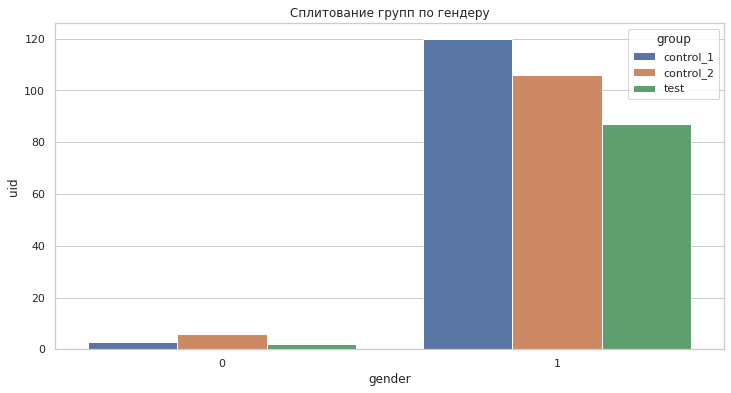

In [177]:
sns.barplot(data = gender_df, x = 'gender', y = 'uid', hue = 'group').set_title('Сплитование групп по гендеру')

Визуально кажется, что различия в количестве уникальных пользователей по гендеру есть. Но проверим это статистически.
У нас есть три группы:  test - версия с изменениями, control_1 и control_2 - версии без изменений, а также колонка 'gender', т.к. все переменные - категориальные → нужен хи-квадрат.

- $H_0$: Не обнаружено статистически значимых различий между распределениями пользователей по гендеру в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями пользователей по гендеру в тестовой и контрольных группах.

In [178]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(users.gender, users.group))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 2.0149517623883657
P-значение теста: 0.3651394727756804


In [179]:
0.3651394727756804 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями пользователей по гендеру в тестовой и контрольных группах нет. 

Посмотрим на **распределение возраста между группами.**

In [180]:
A = users_test.age
B = users_control_1.age
C = users_control_2.age

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd973d6f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd96d82fd0>)

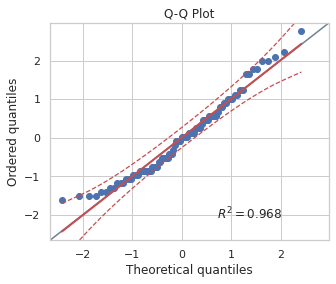

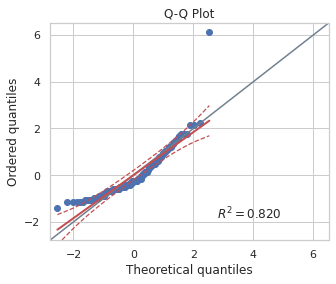

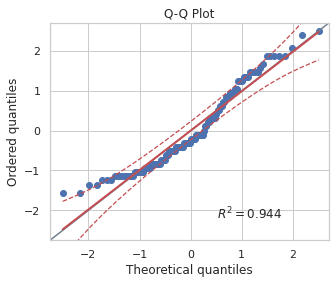

In [181]:
pg.qqplot(A), pg.qqplot(B), pg.qqplot(C)

Распределение на графике qq-plot в каждой группе отличается от нормального (есть выброс, но трогать не будем). Попробуем провести тест на нормальность, используя тест Шапиро-Уилка.

In [182]:
pg.normality(data=users, dv="age", group="group", method="shapiro")

,W,pval,normal
test,0.963459,1.319199e-02,False
control_1,0.829234,1.252842e-10,False
control_2,0.938855,6.515079e-05,False


А что с дисперсиями?

In [183]:
pg.homoscedasticity(data=users, dv="age", group="group")

,W,pval,equal_var
levene,0.066921,0.935283,True


Поскльку дисперсии в трех группах равны, а распределение признака является ненормальным во всех трех группах, то т.к. нас интересует именно распределение возраста по группам, то логично обратиться к тесту Краскела-Уоллиса.

- $H_0$: Не обнаружено статистически значимых различий между распределениями возраста в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями возраста в тестовой и контрольных группах.

In [184]:
scipy.stats.kruskal(users.query('group == "test"')['age'], users.query('group == "control_1"')['age'], users.query('group == "control_2"')['age'])

KruskalResult(statistic=2.850549528869413, pvalue=0.2404423891142278)

In [185]:
0.2404423891142278 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями возраста в тестовой и контрольных группах нет. 

Посмотрим на **распределение количества проведенных дней в приложении**

In [186]:
users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

In [187]:
#изменим тип данных
users['visit_days'] = users['visit_days'].astype('str')

In [188]:
# создадим колонку с количеством проведенных дней на каждого пользователя
def count_days(visit_days):
    if visit_days == '0':
        return 0
    else:
        return len(visit_days.split(','))

users['days'] = users['visit_days'].apply(count_days)

users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test,3
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580,test,9
105,892430988,28,181,0.0,United States of America,"1,2",1,25,31,22,1.0,1.0,12727,test,2
134,891919368,29,250,0.0,France,0,1,26,32,4,1.0,1.0,16536,test,0
148,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",1,20,35,69,1.0,1.0,12597,test,18


In [189]:
users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
days                  int64
dtype: object

In [190]:
users_A = users.query('group == "test"')
users_B = users.query('group == "control_1"')
users_C = users.query('group == "control_2"')
A = users_A.days
B = users_B.days
C = users_C.days

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd96c71390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd96b4ba58>)

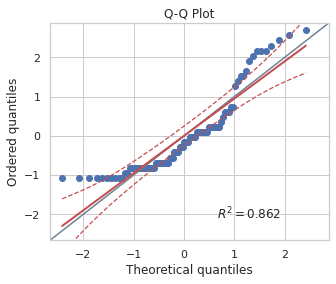

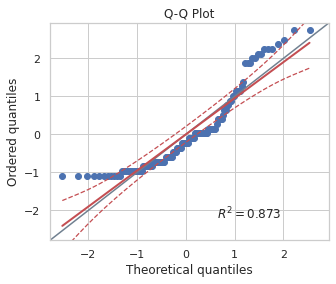

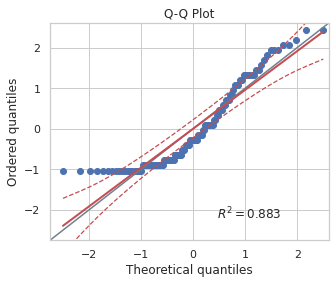

In [191]:
pg.qqplot(A), pg.qqplot(B), pg.qqplot(C)

Распределение на графике qq-plot в каждой группе отличается от нормального. Попробуем провести тест на нормальность, используя тест Шапиро-Уилка.

In [192]:
pg.normality(data=users, dv="days", group="group", method="shapiro")

,W,pval,normal
test,0.855961,7.863156e-08,False
control_1,0.867731,4.369428e-09,False
control_2,0.876131,3.300772e-08,False


Посмотрим на дисперсии:

In [193]:
pg.homoscedasticity(data=users, dv="days", group="group")

,W,pval,equal_var
levene,0.513746,0.598742,True


Поскльку дисперсии в трех группах равны, а распределение признака является ненормальным во всех трех группах, то т.к. нас интересует именно распределение количества дней в приложении по группам, то логично обратиться к тесту Краскела-Уоллиса.

- $H_0$: Не обнаружено статистически значимых различий между распределениями количества дней в приложении в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями количества дней в приложении в тестовой и контрольных группах.

In [194]:
scipy.stats.kruskal(users.query('group == "test"')['days'], users.query('group == "control_1"')['days'], users.query('group == "control_2"')['days'])

KruskalResult(statistic=0.8625125197444008, pvalue=0.6496923993493356)

In [195]:
0.6496923993493356 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями количества дней в приложении в тестовой и контрольных группах нет. 

Посмотрим на **распределение количества внутренней валюты.**

In [196]:
A = users_test.coins
B = users_control_1.coins
C = users_control_2.coins

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd96aadf28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd96a0ffd0>)

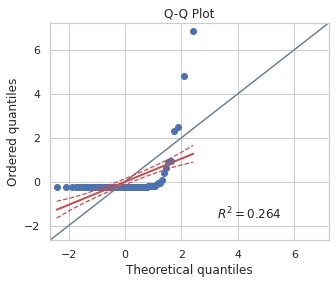

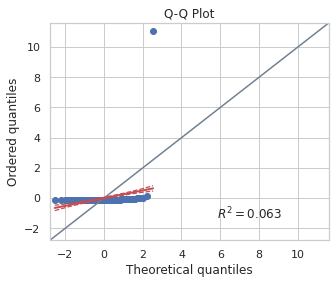

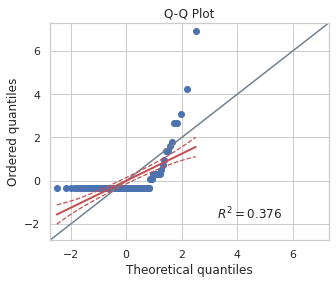

In [197]:
pg.qqplot(A), pg.qqplot(B), pg.qqplot(C)

Распределение на графике qq-plot в каждой группе отличается от нормального (c выбросами, но удалять экстремальные значения не будем). Попробуем провести тест на нормальность, используя тест Шапиро-Уилка.

In [198]:
pg.normality(data=users, dv="coins", group="group", method="shapiro")

,W,pval,normal
test,0.278747,7.181002e-19,False
control_1,0.073346,2.233288e-24,False
control_2,0.387906,1.512097e-19,False


Посмотрим на дисперсии:

In [199]:
pg.homoscedasticity(data=users, dv="coins", group="group")

,W,pval,equal_var
levene,0.611961,0.542918,True


Поскльку дисперсии в трех группах равны, а распределение признака является ненормальным во всех трех группах, то т.к. нас интересует именно распределение количества внутренней валюты по группам, то снова будет логичным обратиться к тесту Краскела-Уоллиса.

- $H_0$: Не обнаружено статистически значимых различий между распределениями количества внутренней валюты в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями количества внутренней валюты в тестовой и контрольных группах.

In [200]:
scipy.stats.kruskal(users.query('group == "test"')['coins'], users.query('group == "control_1"')['coins'], users.query('group == "control_2"')['coins'])

KruskalResult(statistic=0.2171134013778598, pvalue=0.8971280255977151)

In [201]:
0.8971280255977151 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями количества внутренней валюты в тестовой и контрольных группах нет. 

Посмотрим на распределение **числа полученных оценок**. 

In [202]:
A = users_test.views_count
B = users_control_1.views_count
C = users_control_2.views_count

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd96965f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd968f9198>)

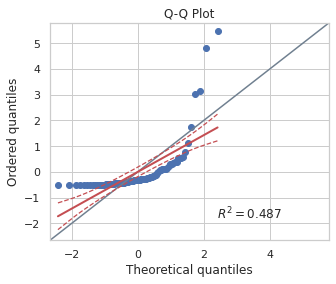

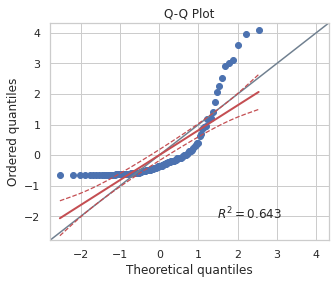

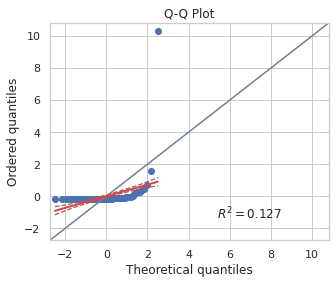

In [203]:
pg.qqplot(A), pg.qqplot(B), pg.qqplot(C)

Распределение на графике qq-plot в каждой группе отличается от нормального (здесь тоже (как и у валюты) есть выбросы, но удалять экстремальные значения не будем). Попробуем провести тест на нормальность, используя тест Шапиро-Уилка.

In [204]:
pg.normality(data=users, dv="views_count", group="group", method="shapiro")

,W,pval,normal
test,0.498841,6.633597e-16,False
control_1,0.644805,7.958290e-16,False
control_2,0.140904,1.185362e-22,False


Взглянем на дисперсии:

In [205]:
pg.homoscedasticity(data=users, dv="views_count", group="group")

,W,pval,equal_var
levene,1.235368,0.292106,True


Поскльку дисперсии в трех группах равны, а распределение признака является ненормальным во всех трех группах, то т.к. нас интересует именно распределение числа полученных оценок по группам, то и в этой ситуации будет логичным обратиться к тесту Краскела-Уоллиса.

- $H_0$: Не обнаружено статистически значимых различий между распределениями числа полученных оценок в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями числа полученных оценок в тестовой и контрольных группах.

In [206]:
scipy.stats.kruskal(users.query('group == "test"')['views_count'], users.query('group == "control_1"')['views_count'], users.query('group == "control_2"')['views_count'])

KruskalResult(statistic=2.6758959542059904, pvalue=0.2623835335546191)

In [207]:
0.2623835335546191 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями числа полученных оценок в тестовой и контрольных группах нет. 

Посмотрим на распределение **коэффициента привлекательности**.

In [208]:
A = users_test.attraction_coeff
B = users_control_1.attraction_coeff
C = users_control_2.attraction_coeff

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd96a1f4e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd972f5208>)

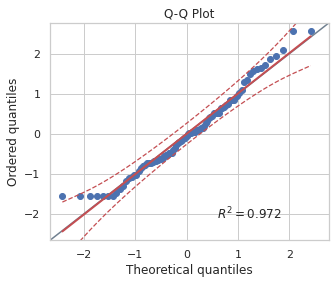

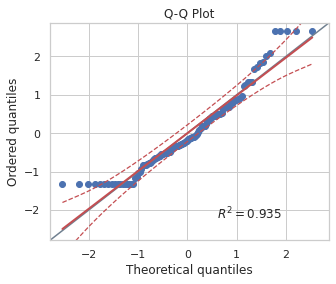

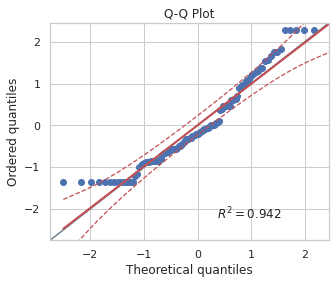

In [209]:
pg.qqplot(A), pg.qqplot(B), pg.qqplot(C)

Распределение на графике qq-plot в каждой группе отличается от нормального. Попробуем провести тест на нормальность, используя тест Шапиро-Уилка.

In [210]:
pg.normality(data=users, dv="attraction_coeff", group="group", method="shapiro")

,W,pval,normal
test,0.966572,0.021471,False
control_1,0.929979,0.000008,False
control_2,0.934800,0.000036,False


Что с дисперсиями?

In [211]:
pg.homoscedasticity(data=users, dv="attraction_coeff", group="group")

,W,pval,equal_var
levene,0.707104,0.493836,True


Поскльку дисперсии в трех группах равны, а распределение признака является ненормальным во всех трех группах, то т.к. нас интересует именно распределение коэффициента привлекательности по группам, то и в этой ситуации будет логичным обратиться к тесту Краскела-Уоллиса.

- $H_0$: Не обнаружено статистически значимых различий между распределениями коэффициента привлекательности в тестовой и контрольных группах.
- $H_1$: Существуют статистически значимые различия между распределениями коэффициента привлекательности в тестовой и контрольных группах.

In [212]:
scipy.stats.kruskal(users.query('group == "test"')['attraction_coeff'], users.query('group == "control_1"')['attraction_coeff'], users.query('group == "control_2"')['attraction_coeff'])

KruskalResult(statistic=2.6074204427113745, pvalue=0.2715225132389092)

In [213]:
0.2715225132389092 < 0.05

False

*Вывод*: Т.к. полученное значение p-value больше 0,05, то нулевая гипотеза не может быть отвергнута.Значимых различий между распределениями коэффициента привлекательности в тестовой и контрольных группах нет.

В заключении посмотрим еще на внутригрупповую корреляцию, чтобы убедиться в схожести групп между собой.

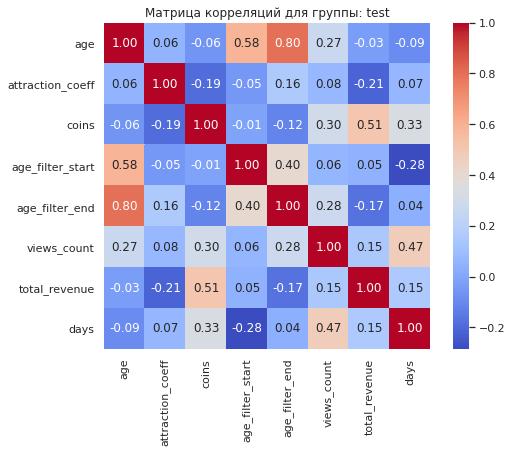

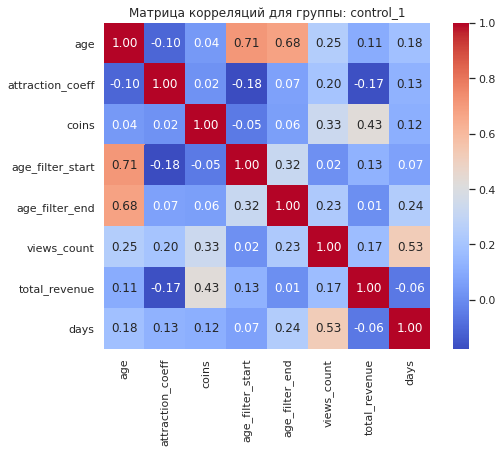

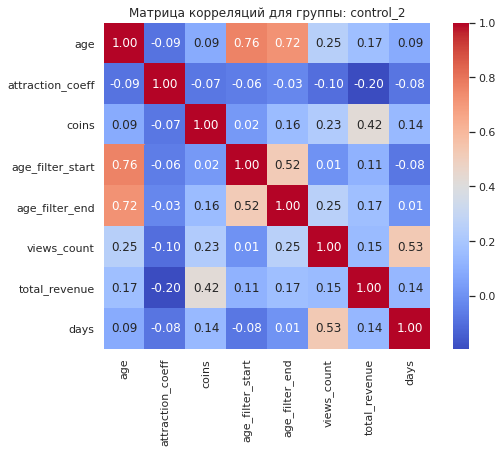

In [214]:
# Выберем количественные признаки
quantitative_features = ['age', 'attraction_coeff', 'coins', 
                         'age_filter_start', 'age_filter_end', 
                         'views_count', 'total_revenue', 'days']

# Разделим данные на группы
groups = users['group'].unique()

# Построим матрицы корреляций для каждой группы
for group in groups:
    group_data = users[users['group'] == group][quantitative_features]
    correlation_matrix = group_data.corr(method='spearman') # Спирмен, т.к. распределения ненормальные
    
    # Построим тепловые карты
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(f'Матрица корреляций для группы: {group}')
    plt.show()

Информация на матрицах указывает на то, что во всех трех группах наблюдается достаточно сильная внутригрупповая коррелляция между возрастом и возрастными фильтрами (для всех трех групп особенно между возрастом и верхней возрастной границей). Вероятно, возраст пользователей влияет на то, какие возрастные фильтры они устанавливают. Поэтому сравнивать распределение еще и фильтров между группами действительно не имело смысла, достаточно было проверки на распределение возраста. 

Каких-либо сильных отличий в плане корреляции признаков между группами не выявлено, значит, пользователи ведут себя схожим образом во всех трех группах.

 ***Вывод*: проверка пользователей по основным признакам подтвердила репрезентативность выборок, система сплитования выстроена корректно.**

### 3. Проверка гипотез. A/B-тестирование.

Попробуем посмотреть, как взаимосвязаны в группах: 
 - пользователи и премиум-аккаунт
 - выручка и все платящие пользователи
 - выручка и платящие за премиум-подписку пользователи

Для этого рассмотрим три метрики для сравнения тестовой и контрольных групп:

- отток пользователей из обладателей премиум-подписки в обычных пользователей (*Churn Rate* - **CR**)
- средняя выручка на одного платящего пользователя (**ARPPU**)
- средняя выручка на одного платящего за премиум-подписку пользователя (**ARPPU_premium**)

Перед проведением тестирования нам нужно создать в общем датасете *users* колонку с категорией пользователя в зависимости от его действий (премиум, экс-премиум, все остальное(другое)).

Для этого, поскольку информация о купленном продукте содержится в датасетах transactions (колонка product_type), нам следует сначала объединить все датасеты transactions через concat (по аналогии с users).

In [215]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [216]:
transactions['product_type'].unique()

array(['trial_premium', 'premium_no_trial', 'other_type'], dtype=object)

In [217]:
users_corr = users[['uid', 'country', 'group', 'was_premium', 'is_premium']]

In [218]:
# смерджим датасеты users_corr и transactions по id пользователя, стране и группе во временный датасет df_merged
df_merged = transactions.merge(users_corr, how = 'outer', on = ['uid', 'country', 'group'])
df_merged

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,was_premium,is_premium
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test,1.0,1.0
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test,1.0,1.0
2,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test,1.0,1.0
3,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,test,1.0,0.0
4,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,test,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
319,892032072,United Kingdom (Great Britain),2017-10-22 14:21:00,2017-10-23 15:37:00,3588,68,none,premium_no_trial,control_2,1.0,0.0
320,891435993,Canada,2017-03-11 21:08:00,2017-03-11 21:26:00,3549,68,none,premium_no_trial,control_2,1.0,0.0
321,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium,control_2,1.0,1.0
322,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium,control_2,1.0,1.0


In [219]:
df_merged['uid'].nunique()

324

In [220]:
# создадим колонку status и зафиксируем в ней изменения в премиум-подписке и все остальное(другое)
def status(was_premium, is_premium, product_type):
    if was_premium == 1 and is_premium == 1 and product_type == 'premium_no_trial':
        return 'premium'
    if was_premium == 1 and is_premium == 0 and product_type == 'premium_no_trial':
        return 'ex_premium'
    else:
        return 'others'
df_merged['status'] = df_merged.apply(lambda x: status(x.was_premium, x.is_premium, x.product_type), axis = 1)

In [221]:
df_merged

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,was_premium,is_premium,status
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test,1.0,1.0,others
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test,1.0,1.0,others
2,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test,1.0,1.0,others
3,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,test,1.0,0.0,ex_premium
4,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,test,1.0,1.0,premium
...,...,...,...,...,...,...,...,...,...,...,...,...
319,892032072,United Kingdom (Great Britain),2017-10-22 14:21:00,2017-10-23 15:37:00,3588,68,none,premium_no_trial,control_2,1.0,0.0,ex_premium
320,891435993,Canada,2017-03-11 21:08:00,2017-03-11 21:26:00,3549,68,none,premium_no_trial,control_2,1.0,0.0,ex_premium
321,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium,control_2,1.0,1.0,others
322,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium,control_2,1.0,1.0,others


In [222]:
df_merged.groupby(['group', 'status']).size()

group      status    
control_1  ex_premium    11
           others        50
           premium       62
control_2  ex_premium     9
           others        30
           premium       73
test       ex_premium     7
           others        43
           premium       39
dtype: int64

#### Приступим к AB-тестированию. ####

**Рассмотрим CR**

In [223]:
# посчитаем количество пользователей, которые отказались от премиум-подписки
number_of_ex_pr = df_merged.query('status == "ex_premium"') \
     .groupby('group', as_index = False) \
     .agg({'uid': 'nunique'}) \
     .rename(columns ={'uid': 'number_of_ex_premium'})

In [224]:
# посчитаем количество пользователей, которые остались в пробном статусе
number_of_stay_pr = df_merged.query('status == "premium"')\
                       .groupby('group', as_index = False) \
                       .agg({'uid': 'nunique'}) \
                       .rename(columns ={'uid': 'number_of_stay_premium'})

In [225]:
df = number_of_stay_pr.merge(number_of_ex_pr, how = 'inner', on = 'group')
df = df.assign(CR = df['number_of_ex_premium'] / (df['number_of_ex_premium'] + df['number_of_stay_premium']) * 100)
df

,group,number_of_stay_premium,number_of_ex_premium,CR
0,control_1,62,11,15.068493
1,control_2,73,9,10.975610
2,test,39,7,15.217391


Визуально видно, что в первой контрольной и тестовой группах примерно 15% пользователей, имевших премиум, отказались от него. Т.е. разницы, вроде, и нет. Cо второй контрольной группой разница есть, т.к. в ней всего 10% пользователей отказались от премиум-подписки. Проверим различия статистически.

**Проведем сначала тестирование на контрольных группах**, если контрольные группы не покажут значимых различий в оттоке, то с тестовой мы сравним какую-то одну из них.

Все переменные - категориальные → нужен хи-квадрат.

- $H_0$: Нет значимых различий в оттоке между контрольной группой 1 и контрольной группой 2.
- $H_1$: Есть значимые различия в оттоке между контрольной группой 1 и контрольной группой 2.

In [226]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(df_merged.query('group != "test" and status != "others"').status, df_merged.query('group != "test" and status != "others"').group))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 0.2690672526017494
P-значение теста: 0.6039581544046662


In [227]:
0.6039581544046662 < 0.05

False

*Вывод*: Поскольку p-значение больше 0.05, нельзя отвергнуть нулевую гипотезу. Значит, нет значимых различий в оттоке между контрольной группой 1 и контрольной группой 2.

Т.к. различий в оттоке между контрольными группами нет, то **проведем AB-тестирование для control_2 и test**.

Все переменные - категориальные → нужен хи-квадрат.

- $H_0$: Нет значимых различий в оттоке между тестовой группой и контрольной группой.
- $H_1$: Есть значимые различия в оттоке между тестовой группой и контрольной группой.

In [228]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(df_merged.query('group != "control_1" and status != "others"').status, df_merged.query('group != "control_1" and status != "others"').group))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 0.17451901227086805
P-значение теста: 0.6761264544763833


In [229]:
0.6761264544763833 < 0.05

False

*Вывод*: Поскольку p-значение больше 0.05, нельзя отвергнуть нулевую гипотезу. Значит, изменение стоимости платной подписки не оказало статистически значимого влияния на метрику CR.

**Рассмотрим ARPPU и ARPPU_pr**

In [230]:
#ARPPU и ARPPU_pr для тестовой группы
revenue_test = df_merged.query('group != "control_2" and group != "control_1"')['revenue'].sum()
users_test = df_merged.query('group != "control_2" and group != "control_1"')['uid'].nunique()
users_test_pr = df_merged.query('group != "control_2" and group != "control_1" and status == "premium"')['uid'].nunique()
ARPPU_test = revenue_test / users_test
ARPPU_test_pr = revenue_test / users_test_pr
test_df = pd.DataFrame({
    'group': ['test'],
    'revenue': [revenue_test],
    'users': [users_test],
    'users_premium': [users_test_pr],
    'ARPPU': [ARPPU_test],
    'ARPPU_pr': [ARPPU_test_pr]
})
test_df

,group,revenue,users,users_premium,ARPPU,ARPPU_pr
0,test,1162759,89,39,13064.707865,29814.333333


In [231]:
#ARPPU и ARPPU_pr для первой контрольной группы
revenue_control_1 = df_merged.query('group != "control_2" and group != "test"')['revenue'].sum()
users_control_1 = df_merged.query('group != "control_2" and group != "test"')['uid'].nunique()
users_control_1_pr = df_merged.query('group != "control_2" and group != "test" and status == "premium"')['uid'].nunique()
ARPPU_control_1 = revenue_control_1 / users_control_1
ARPPU_control_1_pr = revenue_control_1 / users_control_1_pr
control_1_df = pd.DataFrame({
    'group': ['control_1'],
    'revenue': [revenue_control_1],
    'users': [users_control_1],
    'users_premium': [users_control_1_pr],
    'ARPPU': [ARPPU_control_1],
    'ARPPU_pr': [ARPPU_control_1_pr]
})
control_1_df

,group,revenue,users,users_premium,ARPPU,ARPPU_pr
0,control_1,1163279,123,62,9457.552846,18762.564516


In [232]:
#ARPPU и ARPPU_pr для второй контрольной группы
revenue_control_2 = df_merged.query('group != "control_1" and group != "test"')['revenue'].sum()
users_control_2 = df_merged.query('group != "control_1" and group != "test"')['uid'].nunique()
users_control_2_pr = df_merged.query('group != "control_1" and group != "test" and status == "premium"')['uid'].nunique()
ARPPU_control_2 = revenue_control_2 / users_control_2
ARPPU_control_2_pr = revenue_control_2 / users_control_2_pr
control_2_df = pd.DataFrame({
    'group': ['control_2'],
    'revenue': [revenue_control_2],
    'users': [users_control_2],
    'users_premium': [users_control_2_pr],
    'ARPPU': [ARPPU_control_2],
    'ARPPU_pr': [ARPPU_control_2_pr]
})
control_2_df

,group,revenue,users,users_premium,ARPPU,ARPPU_pr
0,control_2,977041,112,73,8723.580357,13384.123288


In [233]:
metrics_ARPPU = pd.concat([test_df, control_1_df, control_2_df]).reset_index(drop=True)
metrics_ARPPU

,group,revenue,users,users_premium,ARPPU,ARPPU_pr
0,test,1162759,89,39,13064.707865,29814.333333
1,control_1,1163279,123,62,9457.552846,18762.564516
2,control_2,977041,112,73,8723.580357,13384.123288


Визуально видно, что метрики ARPPU и ARPPU_pr в тестовой группе значительно выше в сравнении с контрольными группами. Если говорить о контрольных группах, то первая контрольная группа лидирует по данным метрикам. Однако следует подтвердить все статистически.

**Проверим ARPPU**

**Проведем также сначала тестирование на контрольных группах**, если контрольные группы не покажут различий в ARPPU, то с тестовой мы сравним какую-то одну из них.

Проверим нормальность распредления в контрольных группах и дисперсии:

In [234]:
A = df_merged.query('group == "control_1"')['revenue']
B = df_merged.query('group == "control_2"')['revenue']

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd8c4fb7b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd7c564080>)

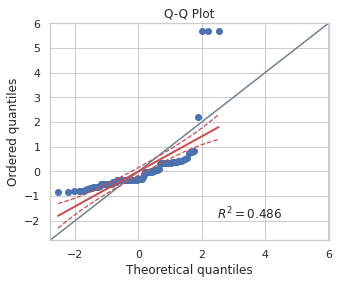

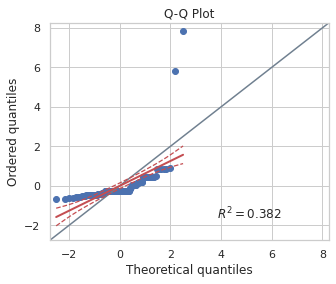

In [235]:
pg.qqplot(A), pg.qqplot(B)

In [236]:
pg.normality(data=df_merged.query('group != "test"'), dv="revenue", group="group", method="shapiro")

,W,pval,normal
control_1,0.495827,1.017225e-18,False
control_2,0.398162,2.127909e-19,False


In [237]:
pg.homoscedasticity(data=df_merged.query('group != "test"'), dv="revenue", group="group")

,W,pval,equal_var
levene,0.464744,0.496092,True


Выручка в обеих группах распределена ненормально, имеются выбросы (но не будем их удалять). Дисперсии же равны.

- Попробуем провести t-тест, выборка достаточно большая, а при большом размере выборки (обычно более 30) центральная предельная теорема гарантирует, что распределение выборочных средних будет приблизительно нормальным независимо от формы распределения исходных данных).

In [238]:
statistic, pvalue = scipy.stats.ttest_ind(df_merged.query('group == "control_1"')['revenue'], df_merged.query('group == "control_2"')['revenue'], equal_var=True)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 0.5968953215400483
p-значение: 0.551156818416471
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


*Вывод*: Тест показал что ARPPU в контрольных группах не различается. 

Т.к. различий в ARPPU между контрольными группами нет, то **проведем AB-тестирование для control_2 и test**.

In [239]:
A = df_merged.query('group == "test"')['revenue']
B = df_merged.query('group == "control_2"')['revenue']

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd7c47a9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd7c44f1d0>)

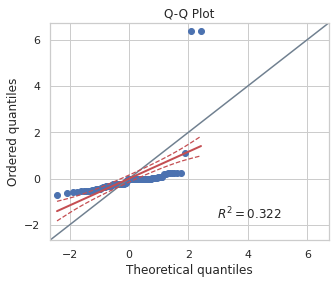

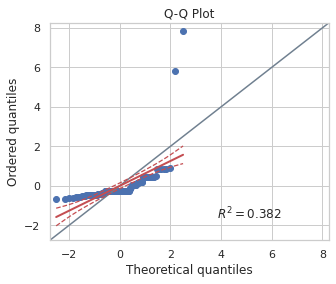

In [240]:
pg.qqplot(A), pg.qqplot(B)

In [241]:
pg.normality(data=df_merged.query('group != "control_1"'), dv="revenue", group="group", method="shapiro")

,W,pval,normal
test,0.337642,3.756697e-18,False
control_2,0.398162,2.127909e-19,False


In [242]:
pg.homoscedasticity(data=df_merged.query('group != "control_1"'), dv="revenue", group="group")

,W,pval,equal_var
levene,1.305111,0.254654,True


Выручка в обеих группах распределена ненормально, имеются выбросы (но не будем их удалять). Дисперсии же равны.
Здесь тоже t-тест должен справиться.

In [243]:
statistic, pvalue = scipy.stats.ttest_ind(df_merged.query('group == "test"')['revenue'], df_merged.query('group == "control_2"')['revenue'], equal_var=True)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 2.413969719623193
p-значение: 0.016685245607151976
Отвергаем нулевую гипотезу. Средние значения выборок различаются


*Вывод*: метрика ARPPU значимо различается в тестовой и контрольной группе. В тестовой группе ARPPU значительно выше.

**Проверим ARPPU_pr**

**Здесь тоже проведем сначала тестирование контрольных групп**, если контрольные группы не покажут различий в ARPPU_pr, то с тестовой мы сравним какую-то одну из них.

In [244]:
A = df_merged.query('group == "control_1" and status == "premium"')['revenue']
B = df_merged.query('group == "control_2" and status == "premium"')['revenue']

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd7c4342e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd7c38beb8>)

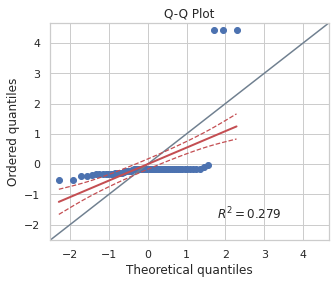

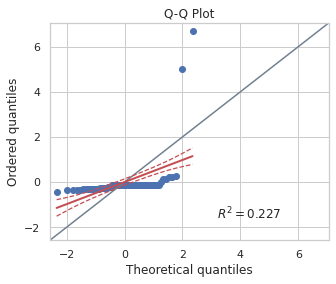

In [245]:
pg.qqplot(A), pg.qqplot(B)

In [247]:
pg.normality(data=df_merged.query('group != "test" and status == "premium"'), dv="revenue", group="group", method="shapiro")

,W,pval,normal
control_1,0.291547,1.001798e-15,False
control_2,0.244636,1.541349e-17,False


In [248]:
pg.homoscedasticity(data=df_merged.query('group != "test" and status == "premium"'), dv="revenue", group="group")

,W,pval,equal_var
levene,0.146675,0.702345,True


Выручка c платящих за премиум-подписку в обеих группах распределена ненормально, имеются выбросы (но не будем их удалять). Дисперсии равны.
Используем t-тест.

In [249]:
statistic, pvalue = scipy.stats.ttest_ind(df_merged.query('group == "control_1" and status == "premium"')['revenue'], df_merged.query('group == "control_2" and status == "premium"')['revenue'], equal_var=True)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 0.32349380880389894
p-значение: 0.746829393705734
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


*Вывод*: Тест показал что ARPPU_pr в контрольных группах не различается. 

Т.к. различий в ARPPU_pr между контрольными группами нет, то **проведем AB-тестирование для control_2 и test**.

In [250]:
A = df_merged.query('group == "test" and status == "premium"')['revenue']
B = df_merged.query('group == "control_2" and status == "premium"')['revenue']

(<matplotlib.axes._subplots.AxesSubplot at 0x7efd96e5f128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efd8c549080>)

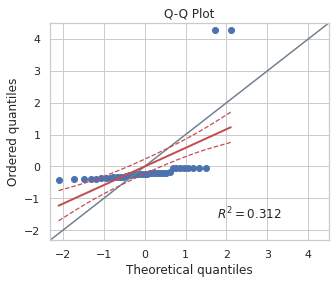

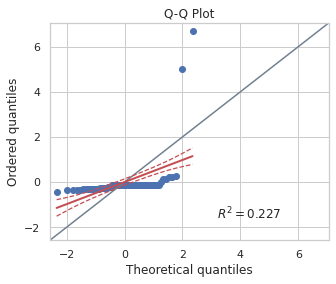

In [251]:
pg.qqplot(A), pg.qqplot(B)

In [252]:
pg.normality(data=df_merged.query('group != "control_1" and status == "premium"'), dv="revenue", group="group", method="shapiro")

,W,pval,normal
test,0.330301,3.881473e-12,False
control_2,0.244636,1.541349e-17,False


In [253]:
pg.homoscedasticity(data=df_merged.query('group != "control_1" and status == "premium"'), dv="revenue", group="group")

,W,pval,equal_var
levene,2.265172,0.135178,True


Выручка c платящих за премиум-подписку в обеих группах распределена ненормально, имеются выбросы (но не будем их удалять). Дисперсии равны.
Используем t-тест.

In [257]:
statistic, pvalue = scipy.stats.ttest_ind(df_merged.query('group == "test" and status == "premium"')['revenue'], df_merged.query('group == "control_2" and status == "premium"')['revenue'], equal_var=True)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 1.7792726372047218
p-значение: 0.07795692433500416
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


*Вывод*: метрика ARPPU_pr значимо не различается в тестовой и контрольной группе.

## Подведение итогов ##

В ходе проведенного эксперимента нет статистически значимых изменений в метриках CR и ARPPU_pr, то есть изменение стоимости премиум-подписки не повлияло на уровень оттока пользователей с премиума на обычные условия, а также изменение стоимости премиум-подписки не повлияло на среднюю выручку на одного платящего за премиум-подписку пользователя. Вероятно, пользователи, предпочитают не изменять своим привычкам потребления или достаточно ценят преимущества премиум-подписки, поэтому не готовы отказываться от них, даже если цена изменилась. Кроме того, пользователи могут не воспринимать новую цену как значительное изменение, или они уже готовы платить текущую цену, т.к. премиум-подписка имеет высокую ценность для пользователей в связи опять же с ее какими-то преимуществами. Однако отсутствие изменений в CR и ARPPU_pr может говорить еще и о том, что пользователи не пришли все же в достаточном количестве, чтобы повлиять на общую выручку от премиум-подписки. Что же касается ARPPU, то, вероятно, при отсутствии изменений в ARPPU_pr, значимые изменения могли быть вызваны другими транзакциями пользователей такими как покупка пробных подписок или дополнительных услуг. Это может указывать на то, что пользователи заинтересованы в продукте и готовы тратить деньги на дополнительные функции. Возможно, увидев изменение стоимости премиум-подписки, пользователи могли потенциально ей заинтересоваться(ведь мы не знаем в какую сторону стоимость изменилась и насколько), но сначала предпочли приобрести пробную подписку для принятия дальнейшего решения о переходе на полную версию. Таким образом, рекомендуется выкатить версию с изменением стоимости премиум-подписки на всех пользователей.